# Anti-cancer activity prediction


## Problem Formulation
This competition is a bioassay task for anticancer activity prediction, where each chemical compound is represented as a graph, with atoms representing nodes and bonds as edges. A chemical compound is positive against non-small cell lung cancer, or negative otherwise. Up to this point, you have learned various tricks and mechanisms to be used for building neural networks/tuning models.

## Data Loading and Exploration
Data format is SDF, we need to read it at first.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from tqdm.notebook import tqdm

def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
        #split each sample alone by ($$$$)
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        #if the label : ==1 leave it as it is, if ==-1 make it 0.
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                #edge represent link between each two nodes
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

In [ ]:
#import spliting function
#read training data and testing too
from sklearn.model_selection import train_test_split
training_set = read_sdf('/content/drive/MyDrive/train[1].sdf')
testing_set  = read_sdf('/content/drive/MyDrive/test_x[1].sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

In [ ]:
#print lenght of our data and dimension
print('length of training_set:', len(training_set))
print('length of traiing_set[0]:', len(training_set[0]))

length of training_set: 25024
length of traiing_set[0]: 3


In [ ]:
#let's see if we have unbalance in data
np.unique(np.array(training_set)[:,2],return_counts=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


(array([0, 1], dtype=object), array([23806,  1218]))

We have 19,043 negative cases and only 976 positive ones.
Here we have unbalanced data.

So we need to up sample positive class.

## Data Visualizing

In [ ]:
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [ ]:
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

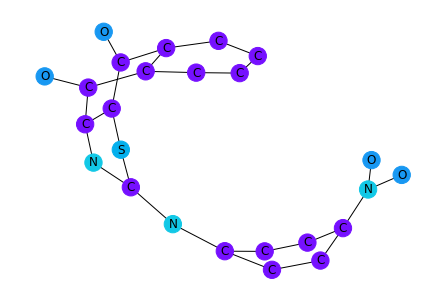

In [ ]:
#visualize sample
visualize(training_set[0])

##Data Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
#convert to data frame to be able to split ones and zeros classes
import pandas as pd
data=pd.DataFrame(training_set,columns=['nodes','edges','labels'])

In [ ]:
data

,nodes,edges,labels
0,"[S, O, O, O, O, N, N, N, C, C, C, C, C, C, C, ...","[[0, 8], [0, 14], [1, 10], [2, 11], [3, 7], [4...",0
1,"[O, O, O, O, O, O, N, N, N, C, C, C, C, C, C, ...","[[0, 6], [0, 15], [1, 15], [2, 7], [3, 8], [4,...",0
2,"[F, F, F, O, O, O, O, O, N, N, C, C, C, C, C, ...","[[0, 19], [1, 19], [2, 19], [3, 16], [4, 28], ...",0
3,"[Cl, S, S, O, O, O, O, N, N, N, N, C, C, C, C,...","[[0, 12], [1, 15], [1, 18], [2, 4], [2, 5], [2...",0
4,"[S, O, O, N, N, N, N, N, N, C, C, C, C, C, C, ...","[[0, 1], [0, 2], [0, 5], [0, 9], [3, 4], [3, 1...",0
...,...,...,...
25019,"[O, O, O, O, O, O, N, N, C, C, C, C, C, C, C, ...","[[0, 8], [0, 14], [1, 10], [2, 12], [3, 13], [...",0
25020,"[O, O, O, O, O, N, C, C, C, C, C, C, C, C, C, ...","[[0, 9], [1, 11], [2, 16], [2, 19], [3, 16], [...",0
25021,"[O, O, O, O, O, O, O, O, O, N, C, C, C, C, C, ...","[[0, 12], [0, 16], [1, 10], [2, 11], [3, 15], ...",0
25022,"[S, O, O, O, O, N, N, N, C, C, C, C, C, C, C, ...","[[0, 11], [0, 12], [1, 21], [1, 27], [2, 22], ...",0


In [ ]:
#split training data to see performance of our model while training
training_set, validation_set = train_test_split(data, test_size=0.2,)

In [ ]:
#label_1 contains data with label 1, label_2 contains data with label 0
label_1=training_set[training_set['labels']==1]
label_2=training_set[training_set['labels']==0]
label_1.shape,label_2.shape

((1218, 3), (23806, 3))

In [ ]:
#resample data of label 1 to fix unbalanced data problems
from sklearn.utils import resample
upsample = resample(label_1,
             replace=True,
             n_samples=len(label_2),
             random_state=42)

In [ ]:
upsample

,nodes,edges,labels
23357,"[O, O, O, O, O, C, C, C, C, C, C, C, C, C, C, ...","[[8, 0], [0, 19], [1, 17], [1, 22], [2, 19], [...",1
17640,"[O, O, O, O, O, O, O, C, C, C, C, C, C, C, C, ...","[[7, 0], [8, 0], [1, 14], [1, 15], [11, 2], [1...",1
23463,"[O, O, N, N, C, C, C, C, C, C, C, C, C, C, C, ...","[[0, 5], [1, 4], [2, 4], [2, 5], [2, 6], [3, 4...",1
22676,"[O, O, O, O, O, O, O, C, C, C, C, C, C, C, C, ...","[[0, 9], [0, 11], [1, 9], [1, 19], [2, 10], [2...",1
21324,"[S, S, O, O, O, O, N, N, C, C, C, C, C, C, C, ...","[[0, 8], [0, 13], [1, 11], [1, 12], [16, 2], [...",1
...,...,...,...
16643,"[O, O, O, O, O, O, N, C, C, C, C, C, C, C, C, ...","[[0, 9], [0, 24], [1, 12], [1, 25], [2, 14], [...",1
5670,"[Cl, O, O, O, O, O, O, O, O, N, N, N, N, C, C,...","[[0, 32], [1, 17], [2, 25], [2, 36], [3, 27], ...",1
4221,"[Cl, Cl, O, O, O, O, N, N, N, C, C, C, C, C, C...","[[0, 30], [1, 31], [2, 15], [2, 27], [3, 13], ...",1
14241,"[Cl, O, O, O, O, O, O, O, O, O, O, C, C, C, C,...","[[30, 0], [11, 1], [14, 1], [2, 13], [2, 22], ...",1


In [ ]:
#display no. od ones in new sampled part
np.unique(np.array(upsample)[:,2],return_counts=True)

(array([1], dtype=object), array([23806]))

In [ ]:
#add sampled ones part to zeros part again
training_set = pd.concat([label_2,upsample])
training_set.shape

(47612, 3)

In [ ]:
#convert data again to tuple list
training_set = training_set.to_records(index=False)
training_set = list(training_set)

In [ ]:
training_set

[(list(['O', 'O', 'O', 'O', 'O', 'N', 'N', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']), array([[ 0, 10],
        [ 0, 11],
        [ 1, 10],
        [ 2, 13],
        [ 3, 15],
        [ 4, 20],
        [ 5, 10],
        [ 5, 13],
        [ 5, 14],
        [ 6, 12],
        [ 6, 15],
        [ 6, 17],
        [ 7, 11],
        [ 7, 20],
        [ 8, 26],
        [ 8, 32],
        [ 8, 39],
        [ 9, 28],
        [ 9, 33],
        [10, 12],
        [11, 13],
        [11, 19],
        [12, 16],
        [14, 15],
        [14, 18],
        [16, 21],
        [17, 21],
        [18, 30],
        [20, 25],
        [22, 24],
        [22, 27],
        [22, 28],
        [23, 24],
        [23, 26],
        [23, 29],
        [24, 34],
        [25, 29],
        [25, 32],
        [26, 31],
        [27, 31],
        [27, 33],
        [28, 35],
        [30, 37],
  

## Building Model

In [ ]:
!pip install --quiet tf2_gnn
from tf2_gnn.layers.gnn import GNN, GNNInput

     |████████████████████████████████| 54 kB 1.8 MB/s 
     |████████████████████████████████| 73 kB 1.3 MB/s 
     |████████████████████████████████| 134 kB 39.8 MB/s 
     |████████████████████████████████| 1.2 MB 24.7 MB/s 
     |████████████████████████████████| 346 kB 49.9 MB/s 
     |████████████████████████████████| 462 kB 34.6 MB/s 
     |████████████████████████████████| 178 kB 43.6 MB/s 
     |████████████████████████████████| 3.6 MB 30.8 MB/s 
     |████████████████████████████████| 79 kB 3.4 MB/s 
     |████████████████████████████████| 85 kB 3.5 MB/s 
     |████████████████████████████████| 41 kB 358 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.


### Model Function

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
#build model function and change in mechanisms
def GNN_model(n,condition,dropout_ratio,hidden_layers,mode,par):
    data = keras.Input(batch_shape=(None,))

    # the first dim is different to the previous one. it is the total number of edges in this batch
    edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
    node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
    embeded = Embedding(tokenizer.num_words, 100)(data)

    # number of graphs (number of samples)
    num_graph = tf.reduce_max(node2graph)+1

    gnn_input = GNNInput(
         node_features=embeded,
         adjacency_lists=(edge,),
         node_to_graph_map=node2graph, 
         num_graphs=num_graph,)

    params = GNN.get_default_hyperparameters()
    params["hidden_dim"] = n 
    params["use_inter_layer_layernorm"]=condition #true or false, default is false
    params["layer_input_dropout_rate"]=dropout_ratio #default is 0
    params['num_aggr_MLP_hidden_layers'] = hidden_layers
    params["global_exchange_mode"]=mode #mean or gru or mlp, default is gru
    params['message_calculation_class']=par #defaulr is rgcn
    gnn_layer = GNN(params)
    gnn_out = gnn_layer(gnn_input)

    print('gnn_out', gnn_out)

    avg = segment_mean(
        data=gnn_out,
        segment_ids=node2graph
    )
    
    print('mean:', avg)
    l1 = Dense(64,activation='relu')(avg) 
    l2 = Dense(64,activation='relu')(l1)
    pred = Dense(1, activation='sigmoid')(l2) 
    print('pred:', pred)

    model = Model(inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,},
     outputs=pred
    )
    return model

In [ ]:
import math
def fit_pred(model):
    batch_size = 16
    num_batchs = math.ceil(len(training_set) / batch_size)
    num_batchs_validation = math.ceil(len(validation_set) / batch_size)

    model.fit(
        gen_batch(
            training_set, batch_size=batch_size, repeat=True
        ),
        steps_per_epoch=num_batchs,
        epochs=30,
        validation_data=gen_batch(
            validation_set, batch_size=16, repeat=True
        ),
        validation_steps=num_batchs_validation,
    )

    y_pred = model.predict(
        gen_batch(testing_set, batch_size=16, shuffle=False)
    )
    y_pred = np.reshape(y_pred, -1)

    import pandas as pd 
    submission = pd.DataFrame({'label':y_pred})
    submission.index.name = 'id'
    return submission.to_csv('sample_submission1.csv')

###First Trial with Relational Graph Convolutional Networks Mechanism
At the first we will try rgcn with default hyperparameters.

Hidden dimension=32

With no layernorm, zero dropout and gru exchange mode.

Trial 1

In [ ]:
model_1=GNN_model(32,False,0,12,'gru','rgcn')

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")


In [ ]:
model_1.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['AUC'])

In [ ]:
fit_pred(model_1)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a larg

2381/2381 [==============================] - 74s 28ms/step - loss: 0.6188 - auc: 0.7128 - val_loss: 0.5796 - val_auc: 0.7610
Epoch 2/30
2381/2381 [==============================] - 66s 28ms/step - loss: 0.5858 - auc: 0.7557 - val_loss: 0.5751 - val_auc: 0.7820
Epoch 3/30
2381/2381 [==============================] - 63s 26ms/step - loss: 0.5606 - auc: 0.7834 - val_loss: 0.5478 - val_auc: 0.8025
Epoch 4/30
2381/2381 [==============================] - 46s 19ms/step - loss: 0.5331 - auc: 0.8092 - val_loss: 0.5088 - val_auc: 0.8339
Epoch 5/30
2381/2381 [==============================] - 47s 20ms/step - loss: 0.5087 - auc: 0.8291 - val_loss: 0.4925 - val_auc: 0.8435
Epoch 6/30
2381/2381 [==============================] - 45s 19ms/step - loss: 0.4927 - auc: 0.8412 - val_loss: 0.4692 - val_auc: 0.8623
Epoch 7/30
2381/2381 [==============================] - 46s 19ms/step - loss: 0.4750 - auc: 0.8541 - val_loss: 0.4596 - val_auc: 0.8651
Epoch 8/30
2381/2381 [==============================] - 45s

###Trail_2 with Gated Graph Neural Networks mechanism
We will try ggnn with default hyperparameters too.

Hidden dimension=32

With no layernorm, zero dropout and gru exchange mode.


In [ ]:
model_2=GNN_model(32,False,0,12,'gru','ggnn')

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")


In [ ]:
model_2.compile(loss='BinaryCrossentropy',metrics=['AUC'])

In [ ]:
fit_pred(model_2)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

2381/2381 [==============================] - 62s 24ms/step - loss: 0.6090 - auc: 0.7251 - val_loss: 0.5595 - val_auc: 0.7891
Epoch 2/30
2381/2381 [==============================] - 58s 24ms/step - loss: 0.5480 - auc: 0.7973 - val_loss: 0.5238 - val_auc: 0.8223
Epoch 3/30
2381/2381 [==============================] - 57s 24ms/step - loss: 0.5137 - auc: 0.8267 - val_loss: 0.4808 - val_auc: 0.8511
Epoch 4/30
2381/2381 [==============================] - 57s 24ms/step - loss: 0.4806 - auc: 0.8515 - val_loss: 0.4533 - val_auc: 0.8721
Epoch 5/30
2381/2381 [==============================] - 56s 24ms/step - loss: 0.4485 - auc: 0.8728 - val_loss: 0.4290 - val_auc: 0.8942
Epoch 6/30
2381/2381 [==============================] - 56s 24ms/step - loss: 0.4220 - auc: 0.8882 - val_loss: 0.4012 - val_auc: 0.9053
Epoch 7/30
2381/2381 [==============================] - 57s 24ms/step - loss: 0.3935 - auc: 0.9033 - val_loss: 0.3836 - val_auc: 0.9131
Epoch 8/30
2381/2381 [==============================] - 65s

### Third Trial with Relational Graph Isomorphism Networks mechanism
And the last trial with default hyperparameters is 'rgin' mechanism

In [ ]:
model_3=GNN_model(32,False,0,12,'gru','rgin')

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_8/Sigmoid:0', description="created by layer 'dense_8'")


In [ ]:
model_3.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['AUC'])

In [ ]:
fit_pred(model_3)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgin_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

2381/2381 [==============================] - 77s 30ms/step - loss: 0.6522 - auc: 0.6613 - val_loss: 0.6301 - val_auc: 0.7027
Epoch 2/30
2381/2381 [==============================] - 71s 30ms/step - loss: 0.6422 - auc: 0.6824 - val_loss: 0.6236 - val_auc: 0.7125
Epoch 3/30
2381/2381 [==============================] - 69s 29ms/step - loss: 0.6264 - auc: 0.7007 - val_loss: 0.6302 - val_auc: 0.6981
Epoch 4/30
2381/2381 [==============================] - 69s 29ms/step - loss: 0.6305 - auc: 0.6974 - val_loss: 0.6370 - val_auc: 0.6950
Epoch 5/30
2381/2381 [==============================] - 69s 29ms/step - loss: 0.6177 - auc: 0.7154 - val_loss: 0.5989 - val_auc: 0.7465
Epoch 6/30
2381/2381 [==============================] - 70s 29ms/step - loss: 0.6181 - auc: 0.7160 - val_loss: 0.6236 - val_auc: 0.7091
Epoch 7/30
2381/2381 [==============================] - 69s 29ms/step - loss: 0.6252 - auc: 0.7023 - val_loss: 0.6232 - val_auc: 0.7046
Epoch 8/30
2381/2381 [==============================] - 69s

### Fourth Trial, we'll try to change hyperparameters

Hidden dimension=32

RGCN mechanism with layernorm, 0.2 dropout and mean exchange mode.


In [ ]:
model_4=GNN_model(32,True,0.2,12,'mean','rgcn')

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_11/Sigmoid:0', description="created by layer 'dense_11'")


In [ ]:
model_4.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['AUC'])

In [ ]:
fit_pred(model_4)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_values:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense

2381/2381 [==============================] - 53s 21ms/step - loss: 0.6099 - auc: 0.7246 - val_loss: 0.5643 - val_auc: 0.7877
Epoch 2/30
2381/2381 [==============================] - 48s 20ms/step - loss: 0.5638 - auc: 0.7797 - val_loss: 0.5438 - val_auc: 0.8075
Epoch 3/30
2381/2381 [==============================] - 48s 20ms/step - loss: 0.5354 - auc: 0.8069 - val_loss: 0.5037 - val_auc: 0.8385
Epoch 4/30
2381/2381 [==============================] - 48s 20ms/step - loss: 0.5151 - auc: 0.8242 - val_loss: 0.5038 - val_auc: 0.8447
Epoch 5/30
2381/2381 [==============================] - 48s 20ms/step - loss: 0.5016 - auc: 0.8346 - val_loss: 0.4747 - val_auc: 0.8614
Epoch 6/30
2381/2381 [==============================] - 48s 20ms/step - loss: 0.4872 - auc: 0.8457 - val_loss: 0.4584 - val_auc: 0.8663
Epoch 7/30
2381/2381 [==============================] - 48s 20ms/step - loss: 0.4756 - auc: 0.8543 - val_loss: 0.4537 - val_auc: 0.8699
Epoch 8/30
2381/2381 [==============================] - 48s

### Trial_5, we'll try to change hyperparameters with GGNN mechanism
Hidden dimension=32

GGNN mechanism with layernorm, 0.2 dropout, mean exchange mode.

In [ ]:
model_5=GNN_model(32,True,0.2,12,'mean','ggnn')

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_14/Sigmoid:0', description="created by layer 'dense_14'")


In [ ]:
model_5.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['AUC'])

In [ ]:
fit_pred(model_5)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

2381/2381 [==============================] - 59s 23ms/step - loss: 0.6073 - auc: 0.7289 - val_loss: 0.5405 - val_auc: 0.8080
Epoch 2/30
2381/2381 [==============================] - 55s 23ms/step - loss: 0.5382 - auc: 0.8055 - val_loss: 0.5094 - val_auc: 0.8321
Epoch 3/30
2381/2381 [==============================] - 56s 23ms/step - loss: 0.5112 - auc: 0.8282 - val_loss: 0.4693 - val_auc: 0.8603
Epoch 4/30
2381/2381 [==============================] - 55s 23ms/step - loss: 0.4867 - auc: 0.8468 - val_loss: 0.4531 - val_auc: 0.8712
Epoch 5/30
2381/2381 [==============================] - 57s 24ms/step - loss: 0.4703 - auc: 0.8581 - val_loss: 0.4261 - val_auc: 0.8872
Epoch 6/30
2381/2381 [==============================] - 56s 24ms/step - loss: 0.4530 - auc: 0.8693 - val_loss: 0.4279 - val_auc: 0.8895
Epoch 7/30
2381/2381 [==============================] - 56s 24ms/step - loss: 0.4366 - auc: 0.8794 - val_loss: 0.4106 - val_auc: 0.8990
Epoch 8/30
2381/2381 [==============================] - 56s

### Trial_6
Hidden dimesion=32

RGIN mechanism with layernorm, 0.2 dropout, 'mean' exchange mode.

In [ ]:
model_6=GNN_model(32,True,0.2,12,'mean','rgin')

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_17/Sigmoid:0', description="created by layer 'dense_17'")


In [ ]:
model_6.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['AUC'])

In [ ]:
fit_pred(model_6)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_values:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense

2381/2381 [==============================] - 79s 31ms/step - loss: 0.6431 - auc: 0.6749 - val_loss: 0.6249 - val_auc: 0.7044
Epoch 2/30
2381/2381 [==============================] - 73s 31ms/step - loss: 0.6596 - auc: 0.6431 - val_loss: 0.6634 - val_auc: 0.6368
Epoch 3/30
2381/2381 [==============================] - 73s 31ms/step - loss: 0.6651 - auc: 0.6319 - val_loss: 0.6626 - val_auc: 0.6388
Epoch 4/30
2381/2381 [==============================] - 73s 31ms/step - loss: 0.6641 - auc: 0.6345 - val_loss: 0.6638 - val_auc: 0.6373
Epoch 5/30
2381/2381 [==============================] - 74s 31ms/step - loss: 0.6627 - auc: 0.6366 - val_loss: 0.6628 - val_auc: 0.6364
Epoch 6/30
2381/2381 [==============================] - 74s 31ms/step - loss: 0.6621 - auc: 0.6372 - val_loss: 0.6657 - val_auc: 0.6365
Epoch 7/30
2381/2381 [==============================] - 74s 31ms/step - loss: 0.6622 - auc: 0.6373 - val_loss: 0.6646 - val_auc: 0.6414
Epoch 8/30
2381/2381 [==============================] - 74s

### Trial_7
Hidden dimesion=64

GGNN mechanism with layernorm, 0.2 dropout, 'gru' exchange mode.

In [ ]:
model_7=GNN_model(64,True,0,12,'gru','ggnn')

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_20/Sigmoid:0', description="created by layer 'dense_20'")


In [ ]:
model_7.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['AUC'])

In [ ]:
fit_pred(model_7)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

2381/2381 [==============================] - 66s 26ms/step - loss: 0.5745 - auc: 0.7697 - val_loss: 0.5195 - val_auc: 0.8292
Epoch 2/30
2381/2381 [==============================] - 61s 26ms/step - loss: 0.4901 - auc: 0.8449 - val_loss: 0.4846 - val_auc: 0.8637
Epoch 3/30
2381/2381 [==============================] - 61s 26ms/step - loss: 0.4643 - auc: 0.8623 - val_loss: 0.4318 - val_auc: 0.8854
Epoch 4/30
2381/2381 [==============================] - 61s 25ms/step - loss: 0.4220 - auc: 0.8876 - val_loss: 0.4341 - val_auc: 0.9146
Epoch 5/30
2381/2381 [==============================] - 63s 26ms/step - loss: 0.3675 - auc: 0.9153 - val_loss: 0.3457 - val_auc: 0.9264
Epoch 6/30
2381/2381 [==============================] - 62s 26ms/step - loss: 0.3308 - auc: 0.9312 - val_loss: 0.2926 - val_auc: 0.9449
Epoch 7/30
2381/2381 [==============================] - 63s 26ms/step - loss: 0.3053 - auc: 0.9406 - val_loss: 0.2803 - val_auc: 0.9497
Epoch 8/30
2381/2381 [==============================] - 62s

### Trial_8
Hidden dimension=64

GGNN mechanism with layernorm, 0 dropout, 'mlp' exchange mode.

In [ ]:
model_8=GNN_model(64,True,0,12,'mlp','ggnn')

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_23/Sigmoid:0', description="created by layer 'dense_23'")


In [ ]:
model_8.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['AUC'])

In [ ]:
fit_pred(model_8)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

2381/2381 [==============================] - 64s 26ms/step - loss: 0.6117 - auc: 0.7234 - val_loss: 0.5583 - val_auc: 0.7960
Epoch 2/30
2381/2381 [==============================] - 59s 25ms/step - loss: 0.5457 - auc: 0.7988 - val_loss: 0.5128 - val_auc: 0.8312
Epoch 3/30
2381/2381 [==============================] - 60s 25ms/step - loss: 0.4959 - auc: 0.8403 - val_loss: 0.4714 - val_auc: 0.8581
Epoch 4/30
2381/2381 [==============================] - 59s 25ms/step - loss: 0.4645 - auc: 0.8620 - val_loss: 0.5091 - val_auc: 0.8622
Epoch 5/30
2381/2381 [==============================] - 59s 25ms/step - loss: 0.4506 - auc: 0.8707 - val_loss: 0.4175 - val_auc: 0.8907
Epoch 6/30
2381/2381 [==============================] - 65s 27ms/step - loss: 0.4202 - auc: 0.8890 - val_loss: 0.4175 - val_auc: 0.8985
Epoch 7/30
2381/2381 [==============================] - 60s 25ms/step - loss: 0.3938 - auc: 0.9031 - val_loss: 0.4226 - val_auc: 0.9148
Epoch 8/30
2381/2381 [==============================] - 60s

**Good performance with 64 hidden dimension let's increase the number and see what will happen.**

### Trial_9
Hidden dimension=128

GGNN mechanism with layernorm, 0 dropout, 'mlp' exchange mode.

Here I changed hidden dimesion to see the effect.

In [ ]:
model_9=GNN_model(128,False,0,12,'mlp','ggnn')

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_8/StatefulPartitionedCall:0', description="created by layer 'gnn_8'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_26/Sigmoid:0', description="created by layer 'dense_26'")


In [ ]:
model_9.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['AUC'])

In [ ]:
fit_pred(model_9)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0",

2381/2381 [==============================] - 64s 26ms/step - loss: 0.6313 - auc: 0.6954 - val_loss: 0.6292 - val_auc: 0.7459
Epoch 2/30
2381/2381 [==============================] - 60s 25ms/step - loss: 0.6041 - auc: 0.7338 - val_loss: 0.6043 - val_auc: 0.7365
Epoch 3/30
2381/2381 [==============================] - 59s 25ms/step - loss: 0.5997 - auc: 0.7343 - val_loss: 0.5960 - val_auc: 0.7468
Epoch 4/30
2381/2381 [==============================] - 60s 25ms/step - loss: 0.5917 - auc: 0.7478 - val_loss: 0.5783 - val_auc: 0.7738
Epoch 5/30
2381/2381 [==============================] - 60s 25ms/step - loss: 0.5903 - auc: 0.7509 - val_loss: 0.5945 - val_auc: 0.7475
Epoch 6/30
2381/2381 [==============================] - 59s 25ms/step - loss: 0.5925 - auc: 0.7462 - val_loss: 0.5931 - val_auc: 0.7637
Epoch 7/30
2381/2381 [==============================] - 60s 25ms/step - loss: 0.5826 - auc: 0.7591 - val_loss: 0.5767 - val_auc: 0.7691
Epoch 8/30
2381/2381 [==============================] - 59s

**After changing hidden dimesion score decreased too much.**

**From 93 to 75**

### Trial_10
Here we'll decrease dimensions to 16 and see what will happen to score.

In [ ]:
model_10=GNN_model(16,False,0,12,'gru','ggnn')

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_9/SegmentMean:0', description="created by layer 'tf.math.segment_mean_9'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_29/Sigmoid:0', description="created by layer 'dense_29'")


In [ ]:
model_10.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['AUC'])

In [ ]:
fit_pred(model_10)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

2381/2381 [==============================] - 54s 22ms/step - loss: 0.6121 - auc: 0.7225 - val_loss: 0.5557 - val_auc: 0.7934
Epoch 2/30
2381/2381 [==============================] - 51s 21ms/step - loss: 0.5501 - auc: 0.7940 - val_loss: 0.5264 - val_auc: 0.8174
Epoch 3/30
2381/2381 [==============================] - 51s 21ms/step - loss: 0.5239 - auc: 0.8176 - val_loss: 0.5146 - val_auc: 0.8398
Epoch 4/30
2381/2381 [==============================] - 51s 21ms/step - loss: 0.5024 - auc: 0.8350 - val_loss: 0.5069 - val_auc: 0.8454
Epoch 5/30
2381/2381 [==============================] - 51s 21ms/step - loss: 0.4855 - auc: 0.8475 - val_loss: 0.4835 - val_auc: 0.8620
Epoch 6/30
2381/2381 [==============================] - 51s 21ms/step - loss: 0.4661 - auc: 0.8608 - val_loss: 0.4416 - val_auc: 0.8786
Epoch 7/30
2381/2381 [==============================] - 51s 21ms/step - loss: 0.4487 - auc: 0.8723 - val_loss: 0.4322 - val_auc: 0.8836
Epoch 8/30
2381/2381 [==============================] - 51s

**The performance is improved with this step.**

##Conclusion
Gated Graph Neural Networks is the best mechanism to fit in this problem.
And no need to use layernorm and drop out layers.

## Problem Formulation

### The Problem is:


Anticancer activity prediction, where each chemical compound is represented as a graph, with atoms representing nodes and bonds as edges. A chemical compound is positive against non-small cell lung cancer, or negative otherwise. Up to this point, you have learned various tricks and mechanisms to be used for building neural networks/tuning models.

### What is the input?


**Nodes :** Each one contains atoms of the chemical compound in the tokenized form.

**Edges :** The relation between each node and others.

**Node2graph :** The input tensor which is used for segmented mean and contains information about segmented ids.



### What is the output?


Probabilities is refering to a chemical compound if it is positive against non-small cell lung cancer, or negative otherwise.

### What data mining function is required?


*   Data split.
*   Data plot and visualization.
*   Data Tokenizer.
*   Data Padding.
*   Reshape.
*   Data resample.
*   Data Concat.
*   Embedding and Dense layers.

### What could be the challenges?


Our data contains characters so we need to tokenize it then apply padding.

Our data is unbalanced too, the positive class is too little we need to resample this data to be good in fitting.

### What is the impact?


We can predict anticancer activity and if a chemical compound is positive against non-small cell lung cancer or not.

### What is an ideal solution?


Model in Trial_2,
Gated Graph Neural Network mecahanism with 32 hidden dimensions, 12 num aggr MLP hidden layers and other default hyperparameters are the best hyperparameters to fit this model.

### What is the experimental protocol used and how was it carried out?


At the first we divided the file into samples, each sample contains node, edge and label. We visualized this sample to be more easier to understand. While checking data we saw that the data is unbalanced so we used resample function to make balance between our data. After that we tokenized data then we applied the GNN model with dense layer. we made alot of trial to compare between each type of hyperparameters in GNN layer as we see above.

#### Hyperparameters were:


*   hidden_dim : we tried (16,32,64,128).
*   use_inter_layer_layernorm : we tried to use it and not to use too.
*   layer_input_dropout_rate : we tried (0,0.2)
*   num_aggr_MLP_hidden_layers : we tried 12.
*   global_exchange_mode : we tried ('mean' , 'mlp' , 'gru')
*   message_calculation_class : we tried multiple mechanism like ('rgcn' , 'ggnn' , 'rgin')



### How did we tune hyper-parameters in the template?


We tried multiple hyperparameters manually and compare the score to find the best ones.

### What is the search space and what is the criteria to determine good/bad hyper-parameters?


The search space was in hyperparameters of GNN layer.

The criteria that used is determine the performance with val loss and auc of the validation sets.

##Questions

### 🌈Based on the provided template, describe the format of the input file (sdf file).

SDF means structure data file. The input file contains information about the chemical compound. SDF file store information about position of individual atom in the chemical compound and also tells about the connections. Different molecules are delimited by '\$\$\$\$' expression.

### 🌈What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?




**nodes**: The data contains the nodes of the chemical compound in the tokenized form. 
 
 The shape of each batch is (batch_size*max_len_nodes), where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes with padding.


**edge**: edge is the input tensor which contains the relation between atoms.

 The shape of each batch is (sum_of_all_edges,2). The sum_of_all_edges represents the sum edges of each sample of the batch_size.


**node2graph**: It is the input tensor which is used for segmented mean and contains information about segmented ids. 

 The shape of each batch is (batch_size*max_len_nodes).

### 🌈For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?



**gnn_out :** It represents the aggregation output of the model for each hidden layer.

**avg :** It is a way of collecting information for each sample and representing it in the form of mean data.

### 🌈What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?



**segment_mean** takes the mean of the data which have same segmented ids. 

**reduce_mean** computes the mean of elements across dimensions of a tensor given the arguments.

**pred** The final output shape is a number which represents the probability associated with each chemical compound about its activity.

### 🌈What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?



Using multiple gcn helps in incorporating all the graph complexity properly.

The default layers are 4 as given in the documentaion.

###Recources

https://analyticsindiamag.com/building-and-modelling-a-graph-neural-network-from-scratch/

https://keras.io/examples/graph/gnn_citations/

https://blog.tensorflow.org/2021/11/introducing-tensorflow-gnn.html